<a href="https://colab.research.google.com/github/ryoheiyoshida/IntroGit/blob/master/%E7%94%BB%E5%83%8F%E5%88%A4%E5%88%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Nagaoka_U_T_DataScience.csv to Nagaoka_U_T_DataScience.csv


In [ ]:
#import

from sklearn.metrics import mean_squared_error, f1_score,  classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.linear_model import LinearRegression #重回帰分析
from sklearn.ensemble import RandomForestRegressor #ランダムフォレスト 
import lightgbm as lgb #LightGBM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


import warnings
# 警告文を非表示
warnings.simplefilter('ignore')
from sklearn.preprocessing import LabelEncoder


In [ ]:
df = pd.read_csv('Nagaoka_U_T_DataScience.csv')
enc = LabelEncoder() 
# fit() #エンコーディング
label_encoder = enc.fit(df[["label"]]) 
# カラムの要素を取得
print('label',label_encoder.classes_)
# transform()で数値へ変換
integer_classes = label_encoder.transform(label_encoder.classes_)
print('Integer classes:',integer_classes)

df["label"] = label_encoder.transform(df[["label"]])


correct_data = df['label'] #正解データ
input_data = df.drop(['label','photo'],axis=1) #訓練データから削除 

input_data.head()



label ['non-residential' 'residential']
Integer classes: [0 1]


,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14391,X14392,X14393,X14394,X14395,X14396,X14397,X14398,X14399,X14400
0,1,0.215686,0.301961,0.219608,0.214706,0.307843,0.223529,0.181373,0.273529,0.180392,...,0.210784,0.190196,0.260784,0.198039,0.202941,0.294118,0.195098,0.159804,0.242157,0.171569
1,2,0.186275,0.263725,0.163725,0.217647,0.302941,0.218627,0.209804,0.301961,0.219608,...,0.198039,0.173529,0.255882,0.197059,0.152941,0.223529,0.172549,0.170588,0.243137,0.172549
2,3,0.140196,0.214706,0.140196,0.244118,0.322549,0.218627,0.144118,0.218627,0.144118,...,0.268627,0.324510,0.318627,0.300980,0.181373,0.251961,0.204902,0.257843,0.301961,0.273529
3,4,0.227451,0.329412,0.215686,0.245098,0.347059,0.241176,0.200980,0.314706,0.200000,...,0.203922,0.223529,0.317647,0.227451,0.223529,0.315686,0.233333,0.160784,0.246078,0.163725
4,5,0.224510,0.314706,0.233333,0.245098,0.276471,0.248039,0.238235,0.304902,0.242157,...,0.162745,0.171569,0.234314,0.191176,0.160784,0.243137,0.168627,0.150980,0.243137,0.146078


In [ ]:
correct_data.head(100)

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Name: label, Length: 100, dtype: int64

In [ ]:
input_data.isnull().sum()

id        0
X1        0
X2        0
X3        0
X4        0
         ..
X14396    0
X14397    0
X14398    0
X14399    0
X14400    0
Length: 14401, dtype: int64

In [ ]:
def split(input,correct):
  
  x1, z1, x2, z2 = train_test_split(input, correct, test_size=0.2)
  x1, y1, x2, y2 = train_test_split(x1,x2,test_size=0.5)
  x3 = pd.concat([x2,y2,z2])
  return x1, y1, z1, x2, y2, z2, x3

# input_train, input_valid, input_test, correct_train, correct_valid, correct_test co_data= split(input_data, correct_data)




In [ ]:
def svm(x_tr, y_tr, x_ts, y_ts):
  from sklearn import svm  
  
  clf = svm.SVC()
  clf.fit(x_tr,y_tr)  #学習
  predict_data = clf.predict(x_ts) #予測

  result = mean_squared_error(y_ts, predict_data)
  result2 = f1_score(y_ts, predict_data)

  return result,result2

# svm(input_train,correct_train,input_test,correct_test)


In [ ]:
def stacking(in_tr, co_tr, in_val, co_val, in_tes, co_tes):
    

  # モデルのインスタンス
  model_1 = LinearRegression()
  model_2 = RandomForestRegressor()
  model_3 = lgb.LGBMRegressor()

  # モデルの学習
  model_1.fit(in_tr, co_tr)
  model_2.fit(in_tr, co_tr)
  model_3.fit(in_tr, co_tr)

  pre_1 = model_1.predict(in_tr)
  pre_2 = model_2.predict(in_tr)
  pre_3 = model_3.predict(in_tr)
  stack_pre = np.column_stack((pre_1,pre_2,pre_3))
  

  # 予測値の作成
  pred_1 = model_1.predict(in_tes)
  pred_2 = model_2.predict(in_tes)
  pred_3 = model_3.predict(in_tes)

  # 第一段階の予測値
  first_pred_1 = model_1.predict(in_val)
  first_pred_2 = model_2.predict(in_val)
  first_pred_3 = model_3.predict(in_val)

  # 第一段階の予測値をまとめる（メタモデルの特徴量）
  stack_pred = np.column_stack((first_pred_1,first_pred_2,first_pred_3))

  # メタモデルの作成
  from sklearn import svm 
  meta_model = svm.SVC()
  # 第一段階の予測値の答え = correct_valid
  meta_model.fit(stack_pred, co_val)

  # 事前に予測しておいた値でスタッキングの精度を確認する
  stack_test_pred = np.column_stack((pred_1, pred_2, pred_3))
  meta_test_pred = meta_model.predict(stack_test_pred)

  result = mean_squared_error(co_tes, meta_test_pred)
  result2 = f1_score(co_tes, meta_test_pred)

  stack_data = np.vstack((stack_pred,stack_test_pred))
  stack_data = np.vstack((stack_pre,stack_data))  
  
  return result, result2, meta_test_pred, stack_data


# res1, res2, stack_test_pred = stacking(input_train, correct_train, input_valid, correct_valid, input_test, correct_test)
# print(res1,res2)

In [ ]:
def cross_val():
  logreg = LogisticRegression()
  sc = "f1"
 
  # 交差検証
  scores = cross_val_score(logreg, stack_data, co_data, scoring = sc, cv=5)

  #F1スコア
  f1_score = scores.mean()

  return scores, f1_score

# cross_val()


In [ ]:
total_svm = 0
total_stack = 0
total_cross = 0
times = 20

for i in range(times):
  input_train, input_valid, input_test, correct_train, correct_valid, correct_test, co_data = split(input_data, correct_data)

  print(i+1,"回目：")
  
  svm_square, svm_f1 = svm(input_train,correct_train,input_test,correct_test)
  total_svm += svm_f1
  print("(svmの平均2乗誤差: {:.4f}".format(svm_square),'F1 measure: {:.4f})'.format(svm_f1))
  
  stack_square, stack_f1, meta_test_pred, stack_data= stacking(input_train, correct_train, input_valid, correct_valid, input_test, correct_test)
  total_stack += stack_f1
  print("(メタモデルの平均2乗誤差: {:.4f}".format(stack_square),'F1 measure: {:.4f})'.format(stack_f1))
  
  scores, cross_f1 = cross_val()
  total_cross += cross_f1
  print('(Cross-Validation scores: {}'.format(scores),"F1スコア:{:.4f})".format(cross_f1))

mean_svm = total_svm / times
mean_stack = total_stack / times
mean_cross = total_cross / times

print("svmの平均f1スコア:{:.4f}".format(mean_svm),"スタッキングの平均f1スコア:{:.4f}".format(mean_stack),"クロスバリデーション（スタッキング）の平均f1スコア:{:.4f}".format(mean_cross))

1 回目：
(svmの平均2乗誤差: 0.0000 F1 measure: 1.0000)
(メタモデルの平均2乗誤差: 0.0192 F1 measure: 0.9863)
(Cross-Validation scores: [1.         1.         1.         1.         0.98461538] F1スコア:0.9969)
2 回目：
(svmの平均2乗誤差: 0.0385 F1 measure: 0.9737)
(メタモデルの平均2乗誤差: 0.0000 F1 measure: 1.0000)
(Cross-Validation scores: [1.         1.         0.98461538 1.         1.        ] F1スコア:0.9969)
3 回目：
(svmの平均2乗誤差: 0.0577 F1 measure: 0.9552)
(メタモデルの平均2乗誤差: 0.0000 F1 measure: 1.0000)
(Cross-Validation scores: [1. 1. 1. 1. 1.] F1スコア:1.0000)
4 回目：
(svmの平均2乗誤差: 0.0000 F1 measure: 1.0000)
(メタモデルの平均2乗誤差: 0.0192 F1 measure: 0.9855)
(Cross-Validation scores: [1.         1.         1.         0.98461538 0.98461538] F1スコア:0.9938)
5 回目：
(svmの平均2乗誤差: 0.0192 F1 measure: 0.9846)
(メタモデルの平均2乗誤差: 0.0000 F1 measure: 1.0000)
(Cross-Validation scores: [1. 1. 1. 1. 1.] F1スコア:1.0000)
6 回目：
(svmの平均2乗誤差: 0.0000 F1 measure: 1.0000)
(メタモデルの平均2乗誤差: 0.0000 F1 measure: 1.0000)
(Cross-Validation scores: [1. 1. 1. 1. 1.] F1スコア:1.0000)
7 回目：
(svm

In [ ]:
# 評価指標を算出
print(classification_report(correct_test, meta_test_pred, target_names=['non-residential', 'residential']))

                 precision    recall  f1-score   support

non-residential       1.00      1.00      1.00        14
    residential       1.00      1.00      1.00        38

       accuracy                           1.00        52
      macro avg       1.00      1.00      1.00        52
   weighted avg       1.00      1.00      1.00        52



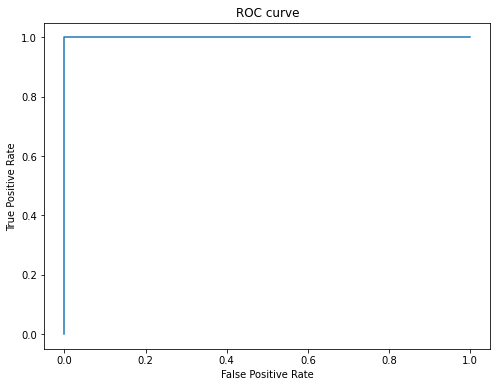

In [ ]:
fpr, tpr, thresholds= roc_curve(correct_test, meta_test_pred)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
# AUCの算出　※値が1になるほど精度が良い
precision, recall, thresholds = precision_recall_curve(correct_test, meta_test_pred)
area = auc(recall, precision)
print("Area Under Curve: {0:.3f}".format(area))

Area Under Curve: 1.000
